## OOI M2M and Altair Tutorial

Note: this was completed with gracious assistance from Friedrich Knuth (who has done this sort of thing many times over). Thank you!

This tutorial will demonstrate how to obtain Ocean Observatories Initiative (OOI) data using M2M (Machine to Machine), in json format, and visualize using Altair.

OOI: https://ooi-visualocean.whoi.edu/
M2M: https://oceanobservatories.org/ooi-m2m-interface/
Prophet: https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/
Altair: https://altair-viz.github.io/


In [1]:
import requests
import json
import re
import os
import altair as alt 
import pandas as pd
import datetime

### Part One: Loading OOI Data

#### Step 1: Enter API Credentials

If you do not have an account on the OOI data portal, navigate to: https://ooinet.oceanobservatories.org/ and create an account. Access your username and token through your user profile.

In [2]:
API_USERNAME = 'OOIAPI-C8PXRLK9NX8K2Y'
API_TOKEN = 'TEMP-TOKEN-MQSQUZIWB1C2M3'

#### Step 2: Enter Instrument Information

Through the OOI data team portal: https://ooi-visualocean.whoi.edu/ find a device you would like extract data from. For this example, the following device is used: https://ooi-visualocean.whoi.edu/instruments/view/GS01SUMO-SBD12-06-METBKA000

Enter device information as follows, and assemble a request URL for the device.

In [3]:
site = 'GS01SUMO'
node = 'SBD12'
instrument = '06-METBKA000'
method = 'recovered_host'
stream = 'metbk_hourly'
api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'

# create request URL
data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

#### Step 3: Indicate Date Range and Options

Enter the date range you are interested in examining. "Daily stats" and "monthly stats" on the OOI data team portal website are helpful tools for this. Use 'limit' to specify the number of json data points you would like to limit extraction to. 

In [4]:
params = {
    'beginDT':'2012-10-18T00:00:00.000Z',
    'endDT':'2018-10-27T00:00:00.000Z',
    'limit':'1000' #20000 is maximum limit
}

#### Step 4: Request Data from the OOI THREDDS server

Note, this may have a long runtime, depending on your date range and limit value.

In [5]:
r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))

#### Step 5: Convert to Pandas DataFrame

In this tutorial, we will examine the dataset in pandas dataframe format, which interfaces nicely with altair. Take a look at how the data is formatted and see which measruements are available.

In [40]:
data = r.json()
df = pd.DataFrame(data)
df.head(10)

met_mommflx_qc_executed  met_tempskn_qc_results  met_latnflx  \
0                       16                      28          NaN   
1                       16                      28          NaN   
2                       16                      28          NaN   
3                       16                      29     3.130428   
4                       16                      29     1.824751   
5                       16                      28          NaN   
6                       16                      29    53.053987   
7                       16                      29     5.405764   
8                       16                      28          NaN   
9                       16                      28          NaN   

   metbk_a_dcl_instrument_recovered-barometric_pressure  \
0                                        1019.437970      
1                                        1012.908769      
2                                        1021.289828      
3                                        1014.711752      
4                                         993.888611      
5                                         981.115775      
6                                         998.821500      
7                                        1012.268856      
8                                        1013.465611      
9                                        1005.399536      

   velpt_ab_dcl_instrument_recovered-northward_velocity  met_rainflx  \
0                                           0.184762             NaN   
1                                           0.066933             NaN   
2                                           0.051749             NaN   
3                                          -0.036437        0.000000   
4                                           0.080318        0.011881   
5                                           0.282927             NaN   
6                                           0.086273        0.000000   
7                                          -0.080753        0.000230   
8                                          -0.018386             NaN   
9                                           0.152617             NaN   

   met_netlirr_qc_executed  met_stablty  \
0                       29          NaN   
1                       29          NaN   
2                       29          NaN   
3                       29    -0.002028   
4                       29     0.001075   
5                       29          NaN   
6                       29    -0.020008   
7                       29     0.011808   
8                       29          NaN   
9                       29          NaN   

   metbk_a_dcl_instrument_recovered-relative_humidity  met_heatflx_qc_results  \
0                                          94.325026                       16   
1                                          96.977867                       16   
2                                          85.810276                       16   
3                                          97.443737                       16   
4                                          96.866591                       16   
5                                          92.209193                       16   
6                                          83.744296                       16   
7                                          93.442958                       16   
8                                          94.265369                       16   
9                                          96.739855                       16   

   ...  met_sensflx_qc_executed  met_sphum2m_qc_executed  \
0  ...                       16                       29   
1  ...                       16                       29   
2  ...                       16                       29   
3  ...                       16                       29   
4  ...                       16                       29   
5  ...                       16                       29   
6  ...                       16     

Pro tip: navigate to the OOI data team portal for a handy list of measurement variable names: https://ooi-visualocean.whoi.edu/streams/view/metbk_hourly

#### Step 6: Change Time Format

We need to manually convert ntp seconds to date time for visualization in altair.

In [41]:
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

df['met_timeflx'] = df['met_timeflx'].apply(ntp_seconds_to_datetime)

### Part Two: Altair

Now we'll demonstrate some of altair's capabilities. For this section, we will focus on irradiance data measured by an OOI pyranometer: https://oceanobservatories.org/data-product/netsirr/.

#### Example 1: Simple Timeseries Plot

Examining irradiance over time.

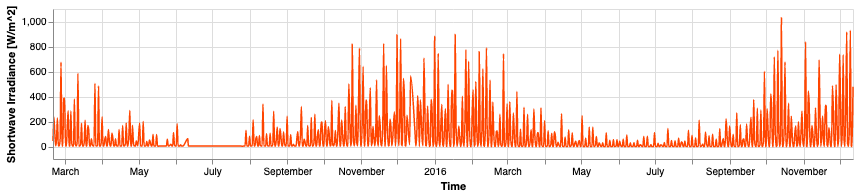

In [42]:
alt.Chart(df).mark_line(
    color='orangered',
    interpolate='monotone',
    strokeWidth=1.5
).encode(
    alt.X('met_timeflx:T', axis = alt.Axis(title='Time')),
    alt.Y('met_netsirr_hourly:Q', axis = alt.Axis(title='Shortwave Irradiance [W/m^2]'))
).properties(
    width=800,
    height=150
)

#### Example 2: Histogram

Examinine average irradiance for each month.

//miniconda3/envs/DataAccess/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


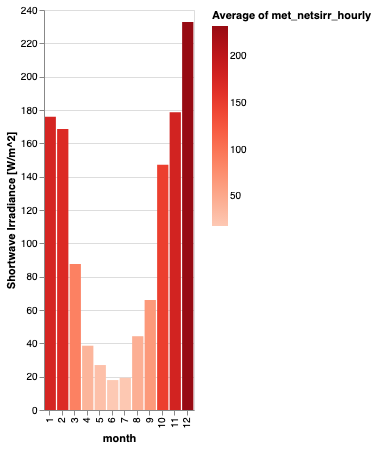

In [54]:
df['met_netsirr_hourly'][df['met_netsirr_hourly'] < 0] = 0 #set negative irradiance values to zero
df['month'] = df['met_timeflx'].dt.month

alt.Chart(df).mark_bar().encode(
    alt.Y('average(met_netsirr_hourly)', axis = alt.Axis(title='Shortwave Irradiance [W/m^2]')),
    alt.X('month:N'),
    alt.Color('average(met_netsirr_hourly)', scale=alt.Scale(scheme='reds'))
).properties(
    width=150,
    height=400
)